In [1]:
import json
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

from python import metrics, data_loader

In [2]:
DATA_DIR = Path("data/processed")
OUTPUT_DIR = Path("out")
TOTAL_FOLDS = 5

image_size = 112
batch_size = 64
max_epochs = 100
lr_scheduler_patience = 10
early_stopping_patience = 20

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
classes_file = DATA_DIR / "classes.json"
with open(classes_file, 'r') as f:
    class_names = json.load(f)
    classes_num = len(class_names)

print(*class_names, sep="\n")

air_conditioner
car_horn
children_playing
dog_bark
drilling
engine_idling
gun_shot
jackhammer
siren
street_music


In [5]:
def new_model():
    return models.Sequential([
        layers.Input(shape=(image_size, image_size, 1)),
        layers.Rescaling(1./255),

        # Block 1
        layers.Conv2D(32, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2D(32, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(64, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2D(64, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        # Block 3
        layers.Conv2D(128, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2D(128, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.4),

        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(classes_num, activation='softmax')
    ])

new_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 112, 112, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 32)     128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 112, 112, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 32)     128       
 hNormalization)                                        

In [6]:
ys_true = []
ys_pred = []

for val_fold in range(1, TOTAL_FOLDS + 1):
    tensorboard_dir = OUTPUT_DIR / "tensorboard" / f"cv{val_fold}"
    model_file = OUTPUT_DIR / f"cv{val_fold}" / "model.keras"
    weights_file = OUTPUT_DIR / f"cv{val_fold}" / "model.weights.h5"
    metrics_file = OUTPUT_DIR / "metrics.json"

    model_file.parent.mkdir(parents=True, exist_ok=True)
    weights_file.parent.mkdir(parents=True, exist_ok=True)

    train_data, val_data = data_loader.load_data(
        data_dir=DATA_DIR,
        val_fold=val_fold,
        total_folds=TOTAL_FOLDS,
        class_names=class_names,
        batch_size=batch_size,
        image_size=image_size
    )

    tensorboard = TensorBoard(log_dir=tensorboard_dir)
    checkpoint = ModelCheckpoint(weights_file, save_best_only=True, save_weights_only=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=lr_scheduler_patience, min_lr=1e-6)
    early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience)

    model = new_model()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[
            'accuracy',
            metrics.F1Macro(classes_num),
            metrics.PrecisionMacro(classes_num),
            metrics.RecallMacro(classes_num)
        ]
    )

    model.fit(
        train_data, epochs=max_epochs, validation_data=val_data, verbose=2,
        callbacks=[
            tensorboard, checkpoint, lr_scheduler, early_stopping
        ]
    )

    model.load_weights(weights_file)
    model.save(model_file)

    fold_metrics = metrics.evaluate_metrics(model, val_data)
    metrics.save_metrics(fold_metrics, metrics_file, val_fold)

    y_true, y_pred = metrics.model_predict(model, val_data)
    ys_true.extend(y_true)
    ys_pred.extend(y_pred)
    print(f"Fold {val_fold}: {fold_metrics}\n")

Found 1761 files belonging to 10 classes.
Found 1915 files belonging to 10 classes.
Found 1759 files belonging to 10 classes.
Found 1644 files belonging to 10 classes.
Found 1653 files belonging to 10 classes.
Epoch 1/100
110/110 - 15s - loss: 1.7685 - accuracy: 0.3641 - f1: 0.3488 - precision: 0.3592 - recall: 0.3490 - val_loss: 2.9374 - val_accuracy: 0.1113 - val_f1: 0.0200 - val_precision: 0.0111 - val_recall: 0.1000 - lr: 0.0010 - 15s/epoch - 135ms/step
Epoch 2/100
110/110 - 9s - loss: 1.3532 - accuracy: 0.5301 - f1: 0.5363 - precision: 0.5568 - recall: 0.5263 - val_loss: 4.8384 - val_accuracy: 0.1113 - val_f1: 0.0200 - val_precision: 0.0111 - val_recall: 0.1000 - lr: 0.0010 - 9s/epoch - 85ms/step
Epoch 3/100
110/110 - 9s - loss: 1.1109 - accuracy: 0.6217 - f1: 0.6315 - precision: 0.6398 - recall: 0.6258 - val_loss: 6.9390 - val_accuracy: 0.1136 - val_f1: 0.0204 - val_precision: 0.0114 - val_recall: 0.1000 - lr: 0.0010 - 9s/epoch - 86ms/step
Epoch 4/100
110/110 - 10s - loss: 0.9766

In [7]:
print("Classification Report: ")
print(classification_report(ys_true, ys_pred))

Classification Report: 
              precision    recall  f1-score   support

           0       0.61      0.55      0.58      1000
           1       0.88      0.81      0.84       429
           2       0.78      0.80      0.79      1000
           3       0.82      0.84      0.83      1000
           4       0.61      0.76      0.67      1000
           5       0.69      0.75      0.72      1000
           6       0.92      0.97      0.94       374
           7       0.77      0.56      0.65      1000
           8       0.92      0.75      0.82       929
           9       0.73      0.87      0.79      1000

    accuracy                           0.75      8732
   macro avg       0.77      0.76      0.76      8732
weighted avg       0.75      0.75      0.75      8732



In [8]:
print("Confusion Matrix: ")
print(confusion_matrix(ys_true, ys_pred))

Confusion Matrix: 
[[548   0  18  54  86 173   1  37  16  67]
 [  7 349   1   6  15   4   5  13   0  29]
 [ 18   0 796  50  14  15   3   4   9  91]
 [ 13  10  66 839  23   7   5   0  16  21]
 [ 51   9  14  17 755  27   8  78  10  31]
 [151   2  15   6  38 750   0  23   0  15]
 [  0   0   0   7   5   0 362   0   0   0]
 [ 69  11   0   1 273  62   7 564   0  13]
 [ 10   5  66  35  21  42   0   0 693  57]
 [ 25  12  41   7  13   8   3  13   8 870]]


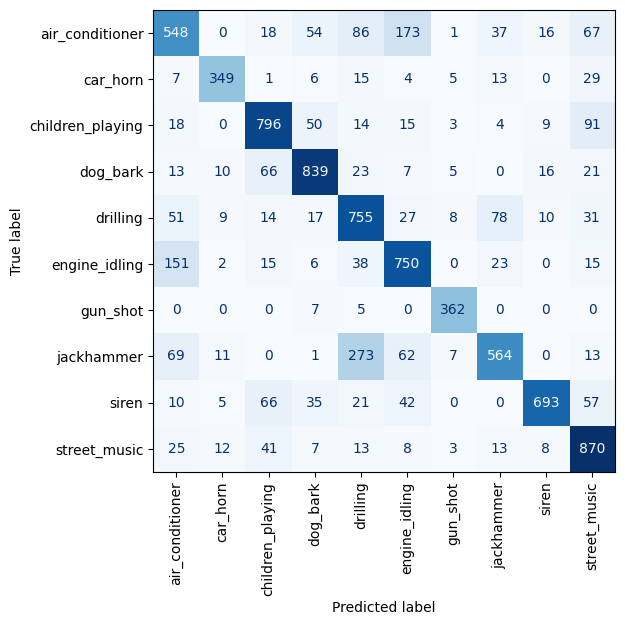

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
cmp = ConfusionMatrixDisplay.from_predictions(
    ys_true, ys_pred,
    display_labels=class_names,
    cmap=plt.get_cmap('Blues'),
    colorbar=False,
    xticks_rotation='vertical',
    ax=ax
)